In [1]:
# v10_240112
# (番目指定印加処理に加え、ShuffleSplitも前処理側へ)

#%%
# 必要に応じてpip
# !pip install --upgrade pip
# !pip install numpy scikit-learn tensorflow matplotlib pillow pandas
# !pip install seaborn

In [2]:
# 機械学習のライブラリ関連をインポート
import pandas as pd
import numpy as np

# 評価指標の計算用
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# 深層学習のライブラリをインポート
import tensorflow as tf
import tensorflow.keras as keras

#表示系のインポートと設定
import matplotlib.pyplot as plt

# ファイル操作
import os

# 画像操作
from PIL import Image

# 時間取得
import datetime

In [3]:
# DIRS
DATASET_NUM = 10000
DIRS_DATASET = "../Training/Datasets_v0108_AfterProcessing/" + str(DATASET_NUM) + ".npz"

In [4]:
# ラベルデータをone-hotベクトル「から」直す
def one_hot_vector_restore(y):
    labels = {
        (1, 0, 0, 0, 0, 0, 0, 0, 0, 0): 0,
        (0, 1, 0, 0, 0, 0, 0, 0, 0, 0): 1,
        (0, 0, 1, 0, 0, 0, 0, 0, 0, 0): 2,
        (0, 0, 0, 1, 0, 0, 0, 0, 0, 0): 3,
        (0, 0, 0, 0, 1, 0, 0, 0, 0, 0): 4,
        (0, 0, 0, 0, 0, 1, 0, 0, 0, 0): 5,
        (0, 0, 0, 0, 0, 0, 1, 0, 0, 0): 6,
        (0, 0, 0, 0, 0, 0, 0, 1, 0, 0): 7,
        (0, 0, 0, 0, 0, 0, 0, 0, 1, 0): 8,
        (0, 0, 0, 0, 0, 0, 0, 0, 0, 1): 9,
    }

    y = np.array([labels[tuple(one_hot)] for one_hot in y])
    return y

In [5]:
# NpzFile形式からXとyを取得
npz_kw = np.load(DIRS_DATASET)
X_train, X_test, y_train, y_test = npz_kw["arr_0"], npz_kw["arr_1"], npz_kw["arr_2"], npz_kw["arr_3"]

In [6]:
X_train.shape[0], X_train.shape[1]

(104000, 337)

In [7]:
X_train

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [8]:
### ニューラルネットワークの構築

# 学習し、テストデータで評価し、スコアを表示する
# 引数は、中間層の数、バッチサイズ、epoch数

def fit_epoch(neuron, batch, epochs, ckpt_period, optimizer_name):
    ver_name = "v10_240112"
    
    # チェックポイントの設定
    dt_now = datetime.datetime.now()
    checkpoint_path = "./training_ckpt_" + dt_now.strftime('%Y%m%d%H%M%S') + "_" + ver_name + "_d" + str(DATASET_NUM) + "_n" + str(neuron)  + "_b" + str(batch) + "_e" + str(epochs) + "_c" + str(ckpt_period) + "_" + optimizer_name + "/cp-{epoch:09d}.ckpt"
    checkpoint_dir = os.path.dirname(checkpoint_path)
    cp_callback = tf.keras.callbacks.ModelCheckpoint(
        checkpoint_path,
        verbose=1,
        save_weights_only=True,
        period=ckpt_period  # 重みをckpt_periodエポックごとに保存します
    )


    # レイヤーのオブジェクトを作成
    Dense = keras.layers.Dense

    # モデルの構造を定義
    model = keras.models.Sequential()
    model.add(tf.keras.layers.Flatten(input_shape=(337, )))
    model.add(Dense(neuron, activation='relu'))
    
    # 畳み込み層を追加
    # model.add(tf.keras.layers.Flatten(tf.keras.layers.Conv2D(filters=neuron, kernel_size=(3, 3), activation='relu', input_shape=(1, 337, 3))))

    model.add(Dense(10, activation='softmax')) # 10つのラベルがありsoftmaxで最後の層作る

    # モデルを構築
    model.compile(
        loss='categorical_crossentropy',
        optimizer=optimizer_name,
        metrics=['accuracy']
    )

    # 必要に応じてチェックポイントから再開
    # model.load_weights("./training_ckpt_20240112021047_v9_240111_d100000_n1024_b32_e8000_c100_Adamax/cp-000000100.ckpt")

    # 学習を実行
    hist = model.fit(X_train, y_train,
        batch_size=batch, # 誤差逆伝播法をするときの1回当たりのデータ数
        epochs=epochs,
        callbacks=[cp_callback],
        verbose=1,
        validation_split=0.1)
    
    # モデルの保存
    model.save("./TrainedModel/" + dt_now.strftime('%Y%m%d%H%M%S') + "_" + ver_name + "_d" + str(DATASET_NUM) + "_n" + str(neuron)  + "_b" + str(batch) + "_e" + str(epochs) + "_"+ optimizer_name)
    
    # モデルを評価
    score = model.evaluate(X_test, y_test, verbose=1)
    print('正解率(Accuracy)=', score[1], 'loss=', score[0])

    # 予測を取得
    predictions = model.predict(X_test)
    predicted_labels = tf.argmax(predictions, axis=1).numpy()
    y_test_restored = one_hot_vector_restore(y_test) # one-hotベクトル「から」直す

    print(predicted_labels)

    # classification_reportを使用して評価指標を表示
    df_report = pd.DataFrame(classification_report(y_test_restored, predicted_labels, output_dict=True)).T
    print(df_report)

    # seabornのヒートマップ
    sns.heatmap(confusion_matrix(y_test_restored, predicted_labels), annot=True)
    plt.xlabel("pred")
    plt.ylabel('true')
    plt.show()
    
    # 学習の様子をグラフへ描画 
    # 正解率の推移をプロット
    plt.plot(hist.history['accuracy'])
    plt.plot(hist.history['val_accuracy'])
    plt.title('Accuracy')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    # ロスの推移をプロット
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.title('Loss')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()   

In [9]:
print(DATASET_NUM)

10000


Epoch 1/1000
732/732 [==============================] - 4s 4ms/step - loss: 2.3665 - accuracy: 0.2208 - val_loss: 2.1547 - val_accuracy: 0.2554
Epoch 2/1000
732/732 [==============================] - 3s 4ms/step - loss: 2.1086 - accuracy: 0.2543 - val_loss: 2.0737 - val_accuracy: 0.2558
Epoch 3/1000
732/732 [==============================] - 2s 3ms/step - loss: 2.0844 - accuracy: 0.2524 - val_loss: 2.1586 - val_accuracy: 0.2433
Epoch 4/1000
732/732 [==============================] - 2s 3ms/step - loss: 2.0693 - accuracy: 0.2527 - val_loss: 2.0635 - val_accuracy: 0.2562
Epoch 5/1000
732/732 [==============================] - 2s 3ms/step - loss: 2.0576 - accuracy: 0.2527 - val_loss: 2.0704 - val_accuracy: 0.2536
Epoch 6/1000
732/732 [==============================] - 2s 3ms/step - loss: 2.0473 - accuracy: 0.2566 - val_loss: 2.0362 - val_accuracy: 0.2571
Epoch 7/1000
732/732 [==============================] - 2s 3ms/step - loss: 2.0344 - accuracy: 0.2586 - val_loss: 2.0753 - val_accuracy:

INFO:tensorflow:Assets written to: ./TrainedModel/20240120224623_v10_240112_d10000_n256_b128_e1000_Adamax\assets


813/813 [==============================] - 2s 2ms/step - loss: 0.5371 - accuracy: 0.7960
正解率(Accuracy)= 0.7959615588188171 loss= 0.5371444225311279
813/813 [==============================] - 1s 2ms/step
[0 1 6 ... 9 5 6]
              precision    recall  f1-score       support
0              0.713403  0.749750  0.731125   2002.000000
1              0.792308  0.704514  0.745836   2193.000000
2              0.794977  0.799724  0.797344   2177.000000
3              0.772894  0.750222  0.761389   2250.000000
4              0.881906  0.838554  0.859684   4150.000000
5              0.803202  0.860037  0.830649   3208.000000
6              0.782284  0.740185  0.760653   2267.000000
7              0.761447  0.725884  0.743240   2291.000000
8              0.741136  0.876070  0.802974   2219.000000
9              0.832356  0.831329  0.831842   3243.000000
accuracy       0.795962  0.795962  0.795962      0.795962
macro avg      0.787591  0.787627  0.786474  26000.000000
weighted avg   0.797456  

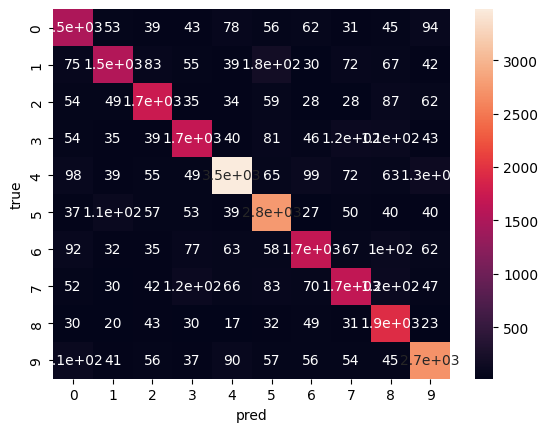

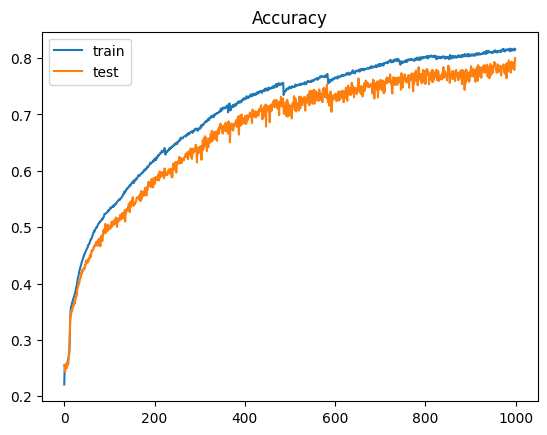

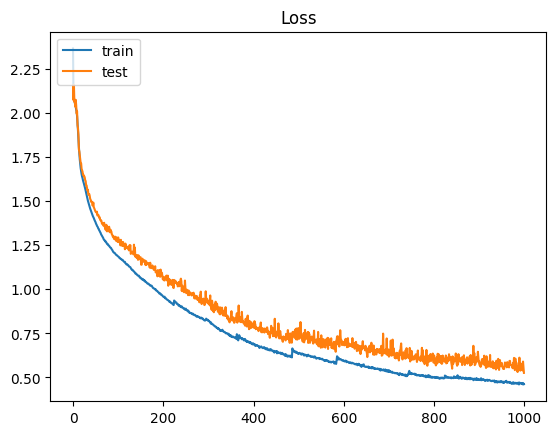

In [11]:
# fit_epoch(中間層の数, バッチサイズ, 学習回数, チェックポイントの作成タイミング, 最適化関数)
fit_epoch(     256,          128,        1000,                  1000000,              "Adamax")